In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -709, 100000)))

In [3]:
# INPUT_DIR = Path('../data/g2net/') # my env
INPUT_DIR = Path('input/')
RESULT_DIR = Path('results/')

In [4]:
train = pd.read_csv(INPUT_DIR/'training_labels.csv')
submission = pd.read_csv(INPUT_DIR/'sample_submission.csv')
submission

,id,target
0,00005bced6,0.5
1,0000806717,0.5
2,0000ef4fe1,0.5
3,00020de251,0.5
4,00024887b5,0.5
...,...,...
225995,ffff4125f1,0.5
225996,ffff9d32a6,0.5
225997,ffff9f4c1f,0.5
225998,ffffa19693,0.5


In [5]:
prediction_list = [
    RESULT_DIR/'pseudo_12',
    RESULT_DIR/'pseudo_seq_04',
    RESULT_DIR/'pseudo_13',
    RESULT_DIR/'pseudo_14',
    RESULT_DIR/'pseudo_seq_07',
    RESULT_DIR/'pseudo_16',
    RESULT_DIR/'pseudo_17',
    RESULT_DIR/'pseudo_18',
    RESULT_DIR/'pseudo_19',
    RESULT_DIR/'pseudo_21',
    RESULT_DIR/'pseudo_23',
    # 
    RESULT_DIR/'pseudo_24',
    RESULT_DIR/'pseudo_10',
    RESULT_DIR/'pseudo_26',
    RESULT_DIR/'pseudo_25',
    RESULT_DIR/'pseudo_07',
    RESULT_DIR/'pseudo_22',
    RESULT_DIR/'pseudo_15',
    RESULT_DIR/'pseudo_seq_03',
    RESULT_DIR/'pseudo_06',
]

In [6]:
def generate_submission_title(predictions):
    predictions = sorted(predictions)
    name = ''
    for path in predictions:
        blocks = path.stem.split('_')
        for block in blocks:
            if block.isnumeric():
                block = int(block)
            elif block == 'pseudo':
                block = ''
            elif len(block) > 2:
                block = block[0]
            name += f'{block}'
        name += ','
    name = name[:-1]
    return name


generate_submission_title(prediction_list)

'6,7,10,12,13,14,15,16,17,18,19,21,22,23,24,25,26,s3,s4,s7'

In [7]:
preds = []
preds_full = []
oofs = []
for path in prediction_list:
    if (path/'outoffolds_tta.npy').exists():
        pred = pd.DataFrame(np.load(path/'predictions_tta.npy').squeeze(2)).transpose()
        oof = np.load(path/'outoffolds_tta.npy')
        print(f'{path.stem}: tta loaded')
    else:
        pred = pd.DataFrame(np.load(path/'predictions.npy').squeeze(2)).transpose()
        oof = np.load(path/'outoffolds.npy')
    oof_score = roc_auc_score(train['target'], oof)
    
#     plt.figure(figsize=(6, 6))
#     sns.histplot(sigmoid(pred))
#     plt.title(f'{path.stem} ({oof_score:.5f})')
#     plt.show()
    
    preds.append(pred.mean(1))
    preds_full.append(pred)
    oofs.append(pd.DataFrame(oof))
preds = pd.concat(preds, axis=1)
oofs = pd.concat(oofs, axis=1)
preds_full = np.stack(preds_full)
preds

pseudo_seq_04: tta loaded
pseudo_seq_07: tta loaded
pseudo_16: tta loaded
pseudo_17: tta loaded
pseudo_19: tta loaded
pseudo_21: tta loaded
pseudo_23: tta loaded
pseudo_24: tta loaded
pseudo_26: tta loaded
pseudo_25: tta loaded
pseudo_22: tta loaded
pseudo_15: tta loaded
pseudo_seq_03: tta loaded


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3.556416,3.623672,3.674771,3.640438,3.698294,3.695126,3.702761,3.638300,3.681769,3.623324,3.641189,3.668511,3.652270,3.694330,3.635939,19.953671,3.665663,3.622541,3.525524,16.685307
1,2.526841,2.272466,2.854929,2.015459,2.842735,2.691669,2.621165,2.762043,2.841326,3.197639,2.911507,2.327274,2.010686,3.209499,2.497596,1.901621,2.830990,2.389437,3.446022,2.799079
2,-0.749766,-0.729712,-1.034253,-0.862772,-0.812925,-0.740768,-0.810836,-0.850931,-0.628314,-0.871489,-0.747846,-0.941239,-0.860499,-0.960425,-0.717095,-0.573959,-0.801593,-0.882719,-0.870870,-0.796380
3,2.861069,1.178456,2.026587,2.868520,2.572916,2.040340,2.165290,2.351616,3.042376,2.688465,2.152841,2.317610,2.227903,2.414080,2.147501,2.805529,2.316418,1.546062,-0.057860,4.009462
4,-1.823731,-1.992641,-1.835818,-1.712122,-1.858264,-2.064215,-2.064487,-1.728418,-1.976675,-2.064275,-2.065874,-1.933584,-1.659486,-1.995601,-2.037062,-1.700149,-2.115231,-1.998840,-1.786138,-1.780744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225995,-1.080941,-1.278794,-0.820005,-1.246652,-1.238723,-1.015987,-1.188301,-1.102047,-1.203107,-1.056144,-1.252050,-1.082090,-0.976202,-1.138051,-1.089216,-0.994559,-1.040132,-0.948822,-0.842667,-0.925371
225996,-0.796088,-1.165028,-1.063954,-1.054357,-1.201973,-1.023651,-1.136409,-0.924673,-1.235037,-1.189982,-1.177410,-0.967754,-1.068180,-1.164571,-1.004095,-0.956799,-1.144696,-0.948119,-1.023843,-0.903930
225997,-0.984720,-1.375081,-1.033520,-0.921270,-1.409441,-1.488287,-1.289929,-1.112341,-1.650655,-1.545279,-1.371935,-1.373541,-1.022074,-1.693603,-1.286428,-0.981557,-1.336920,-1.534473,-1.395556,-1.137851
225998,3.616776,3.615021,3.678975,3.659984,3.680703,3.669879,3.687663,3.635040,3.660640,3.647142,3.637418,3.688073,3.620044,3.670508,3.668473,16.663546,3.646756,3.669099,3.564161,15.011065


In [8]:
preds_full.shape

(20, 226000, 5)

In [9]:
preds = sigmoid(preds)
preds_full = sigmoid(preds_full)
preds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.972251,0.974009,0.975272,0.974430,0.975833,0.975758,0.975938,0.974377,0.975440,0.974000,0.974449,0.975120,0.974723,0.975739,0.974318,1.000000,0.975051,0.973980,0.971405,1.000000
1,0.926002,0.906571,0.945573,0.882411,0.944942,0.936533,0.932211,0.940590,0.944869,0.960745,0.948412,0.911111,0.881914,0.961190,0.923973,0.870075,0.944328,0.916018,0.969112,0.942626
2,0.320872,0.325258,0.262260,0.296760,0.307268,0.322836,0.307712,0.299238,0.347893,0.294945,0.321291,0.280650,0.297235,0.276793,0.328033,0.360324,0.309685,0.292615,0.295073,0.310800
3,0.945888,0.764670,0.883560,0.946268,0.929098,0.884968,0.897089,0.913063,0.954452,0.936343,0.895934,0.910325,0.902727,0.917895,0.895435,0.942974,0.910228,0.824344,0.485539,0.982180
4,0.138987,0.119978,0.137547,0.152889,0.134906,0.112624,0.112597,0.150790,0.121674,0.112618,0.112458,0.126354,0.159831,0.119666,0.115366,0.154446,0.107625,0.119325,0.143547,0.144211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225995,0.253328,0.217756,0.305763,0.223280,0.224658,0.265810,0.233563,0.249356,0.230923,0.258047,0.222346,0.253111,0.273646,0.242678,0.251766,0.270013,0.261124,0.279122,0.300973,0.283865
225996,0.310863,0.237755,0.256555,0.258389,0.231124,0.264317,0.242980,0.284007,0.225301,0.233262,0.235518,0.275328,0.255749,0.237838,0.268137,0.277520,0.241459,0.279263,0.264280,0.288244
225997,0.271956,0.201800,0.262402,0.284699,0.196322,0.184179,0.215865,0.247435,0.161020,0.175769,0.202307,0.202048,0.264624,0.155303,0.216458,0.272583,0.208017,0.177340,0.198522,0.242715
225998,0.973834,0.973789,0.975373,0.974913,0.975414,0.975154,0.975581,0.974295,0.974929,0.974597,0.974355,0.975591,0.973917,0.975169,0.975119,1.000000,0.974587,0.975135,0.972459,1.000000


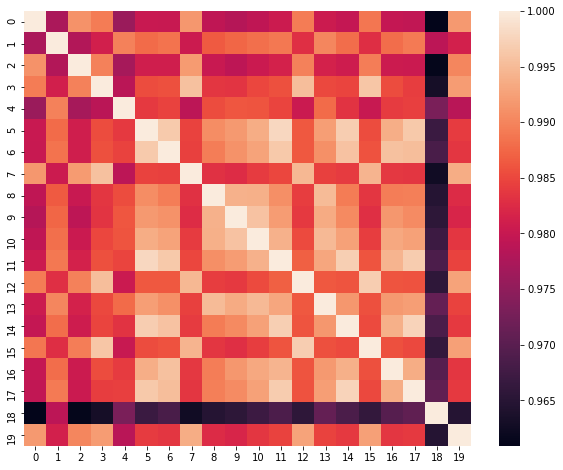

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(preds.corr())
plt.show()

In [11]:
pred_final = preds.mean(1)

# Ridge CV

In [12]:
X, y = sigmoid(oofs).values, train['target'].values
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
pred_final = np.zeros((5, len(submission)), dtype=np.float32)
scores = []
scaler = MinMaxScaler()
for fold, (train_idx, valid_idx) in enumerate(splitter.split(X=train, y=train['target'])):
    X_train, X_valid, y_train, y_valid = X[train_idx], X[valid_idx], y[train_idx], y[valid_idx]
    X_test = preds_full[:, :, fold].transpose()
    stack_model = Ridge(fit_intercept=False)
    stack_model.fit(X_valid, y_valid)
    y_stack = stack_model.predict(X_valid)
    rr_score = roc_auc_score(y_valid, y_stack)
    print(f'[{fold}]Stack model score: {rr_score}')
    print(f'[{fold}]Coef: {stack_model.coef_}')
    print(f'Min {y_stack.min()} / Max: {y_stack.max()}')
    print('\n')
    pred_final[fold] = scaler.fit_transform(
        stack_model.predict(X_test).reshape(-1, 1)).reshape(-1)
    scores.append(rr_score)
print(f'Ridge: {np.mean(scores)}')
pred_final = pred_final.mean(0)
# pred_final = rankdata(pred_final, axis=1).mean(0)

[0]Stack model score: 0.8821623426032588
[0]Coef: [ 0.01528886  0.01305146  0.09403197  0.29086262  0.118719    0.2012709
  0.09371545  0.20084468  0.24542436  0.12137363 -0.0785312   0.03351571
 -0.07233723 -0.15501162  0.16940373 -0.07704034  0.12969209 -0.16750203
 -0.07889215 -0.06278383]
Min 0.04518657550215721 / Max: 1.1564291715621948


[1]Stack model score: 0.8856749903036665
[1]Coef: [ 6.7732729e-02 -7.1605565e-03  9.9457376e-02  2.7464578e-01
  2.9573267e-02  1.1849624e-01  2.6801804e-01  2.5970070e-02
 -6.7140967e-02  7.1549699e-02  2.6376793e-01  7.6432899e-02
 -2.2664061e-02  1.3873513e-01 -3.7515510e-02 -6.1389580e-02
 -3.5948228e-02 -1.1050718e-01 -5.0967824e-02  5.3941825e-05]
Min 0.05018436163663864 / Max: 1.0449004173278809


[2]Stack model score: 0.8816932419680725
[2]Coef: [ 9.3067974e-02  5.2833464e-02  6.9903396e-02  3.2661211e-01
  5.7656538e-02  1.6834362e-01  1.0986558e-01  2.9003316e-01
  7.6220676e-02  2.1560639e-01  1.6362041e-01  2.0726386e-04
 -1.8488993e-

In [13]:
submission['target'] = pred_final

In [14]:
submission

,id,target
0,00005bced6,0.949421
1,0000806717,0.907057
2,0000ef4fe1,0.260920
3,00020de251,0.918684
4,00024887b5,0.078852
...,...,...
225995,ffff4125f1,0.185675
225996,ffff9d32a6,0.209629
225997,ffff9f4c1f,0.192346
225998,ffffa19693,0.949068


In [15]:
submission.to_csv('results/submission.csv', index=False)